# Makemore part 3

In [15]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [16]:
with open('names.txt') as f:
    words = f.readlines()
words = [w.strip() for w in words]
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [17]:
len(words)

32033

In [18]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [19]:
# Build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# Usage examples
#words = words
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
# MLP 
n_emb = 10 # The dimentionality of the character embeddings
n_hidden = 2000 # The number of hidden units in the first layer
g = torch.Generator().manual_seed(2147483647+10) # for reproducibility
C = torch.rand((vocab_size, n_emb),             generator=g)
W1 = torch.rand((n_emb*block_size, n_hidden),   generator=g)*(5/3)*((block_size*n_emb)**-0.5)
b1 = torch.rand(n_hidden,                       generator=g)*0.01
W2 = torch.rand((n_hidden, vocab_size),         generator=g)*0.01
b2 = torch.rand(vocab_size,                     generator=g)*0
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True


In [8]:
lri = []
lossi = []
stepi = []

In [12]:
# same optimization
max_steps = 200000
batch_size = 32
lossi = []
stepi = []

for i in range(max_steps):
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))

    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1) # (32, 60)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain*(hpreact - bnmeani) / bnstdi + bnbias # Batch normalization
    with torch.no_grad():
        bnmean_running = bnmean_running*0.999 + bnmeani*0.001
        bnstd_running = bnstd_running*0.999 + bnstdi*0.001
    h = torch.tanh(hpreact) # output of the tanh layer
    logits = h @ W2 + b2 # outputs layer - layer
    loss = F.cross_entropy(logits, Yb) # loss function
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i<50000 else 0.005
    if i < 50000:
        lr = 0.1
    elif i < 100000:
        lr = 0.005
    else:
        lr = 0.0025
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 == 0:
        print(f"step {i:7d}/{max_steps:7d}: loss {loss.item():.4f}")
    stepi.append(i)
    lossi.append(loss.log10().item())
    #break
    # lri.append(lre[i])
# plt.plot(lri, lossi)
# plt.show()


step       0/ 200000: loss 3.2755
step   10000/ 200000: loss 2.4964
step   20000/ 200000: loss 2.2941
step   30000/ 200000: loss 3.0144
step   40000/ 200000: loss 2.1289
step   50000/ 200000: loss 1.9541
step   60000/ 200000: loss 1.9995
step   70000/ 200000: loss 2.0932
step   80000/ 200000: loss 1.9787
step   90000/ 200000: loss 2.2436
step  100000/ 200000: loss 1.8385
step  110000/ 200000: loss 1.9076
step  120000/ 200000: loss 2.3203
step  130000/ 200000: loss 2.0698
step  140000/ 200000: loss 2.1770
step  150000/ 200000: loss 2.0394
step  160000/ 200000: loss 2.0605
step  170000/ 200000: loss 1.9877
step  180000/ 200000: loss 1.9571
step  190000/ 200000: loss 1.8632


In [119]:
-torch.log(torch.tensor(1/27)) # expected loss in the beginning. -> approximated.

tensor(3.2958)

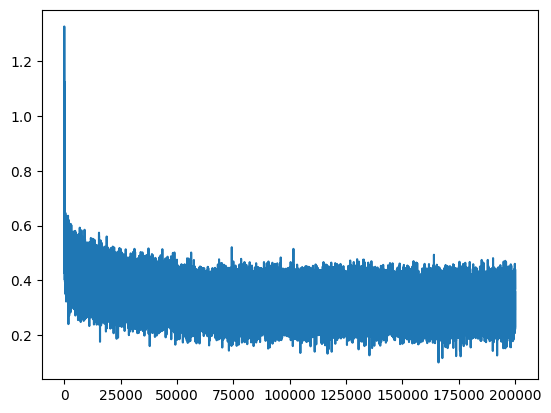

In [124]:
plt.plot(lossi)

In [13]:
# Calibrate the batch norm at the end of training -> required 
# by the batch normalization paper.
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    # measure the mean*std over the entire training set
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)

In [14]:
bnmean_running

tensor([[1.2992, 1.8044, 2.0530,  ..., 2.4844, 1.8349, 1.8986]])

In [23]:
bnstd_running

tensor([[1.6982, 0.9644, 0.6122,  ..., 0.8323, 0.5057, 0.5634]])

In [30]:
torch.max(bnstd - bnstd_running)


tensor(2.4026)

In [34]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # (N, block_size*n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain*(hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss.item()

print(f"train loss: {split_loss('train'):.4f}")
print(f"dev loss: {split_loss('dev'):.4f}")
print(f"test loss: {split_loss('test'):.4f}")


: 

In [ ]:

@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # (N, block_size*n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain*(hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss.item()

print(f"train loss: {split_loss('train'):.4f}")
print(f"dev loss: {split_loss('dev'):.4f}")
print(f"test loss: {split_loss('test'):.4f}")


In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # (N, block_size*n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain*(hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss.item()

print(f"train loss: {split_loss('train'):.4f}")
print(f"dev loss: {split_loss('dev'):.4f}")
print(f"test loss: {split_loss('test'):.4f}")


NameError: name 'bnmean' is not defined

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0]*block_size # initialize with all ...

    while True: 
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        hpreact = e
        h = torch.tanh(emb.view(1,-1)@W1 + b1)
        logits = h@W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))



montaymyah.
seer.
ndyn.
ala.
emmadiendraig.
azeledieli.
jemilopi.
eden.
edo.
naraelyzion.
kamin.
shubergahimier.
kendreth.
khanthony.
ubrence.
ryyah.
faela.
kayshaykella.
hal.
salynn.


In [1]:
# Pytorch way

In [20]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight + (torch.tensor([]) if self.bias is None else (self.bias))]
    
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
            self.running_mean = xmean*self.momentum + (1-self.momentum)*self.running_mean
            self.running_var =xvar*self.momentum + (1-self.momentum)* self.running_var
        else:
            xmean = self.running_mean
            xvar = self.running_var 
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma*xhat + self.beta
        # update the buffers
        if self.training:
            self.gamma.grad = (x*xhat).mean(0)
            self.beta.grad = (x-xhat).mean(0)
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_emb = 10 # the dimensionality of the character embedding vectors 
n_hidden = 100 # the number of neurons in the hidden layer of the NLP
g = torch.Generator().manual_seed(2147483647+10) # for reproducibility
C = torch.rand((vocab_size, n_emb), generator = g)

layers = [
    Linear(n_emb*block_size, n_hidden),Tanh(),
    Linear(n_hidden, n_hidden),Tanh(),
    Linear(n_hidden, n_hidden),Tanh(),
    Linear(n_hidden, n_hidden),Tanh(),
    Linear(n_hidden, n_hidden),Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *=0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters)) # number of parameters in total
lri = []
lossi = []
stepi = []


45970
